# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels.sort_values(by='file_name'))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В нашем распоряжении 7 591 изображение, датасет содержит 2 столбца: `file_name`, отражающий название файла, и `age` - возраст человека на фотографии. Пропущенных значений не обнаружено, а типы данных указаны корректно.

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255
)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(150, 150),
    batch_size=32,
    seed=12346
)

Found 7591 validated image filenames.


In [ ]:
features, target = next(datagen_flow)

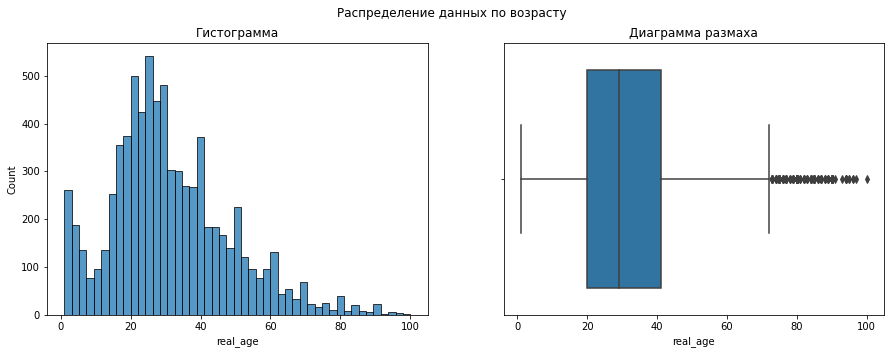

In [ ]:
# Построим график распределения по возрасту
plt.figure(figsize=[15, 5])
plt.suptitle('Распределение данных по возрасту')

plt.subplot(1, 2, 1)
sns.histplot(data=labels, x='real_age')
plt.title('Гистограмма')

plt.subplot(1, 2, 2)
sns.boxplot(data=labels, x='real_age')
plt.title('Диаграмма размаха')
plt.show()

Распределение близко к нормальному, но смещено влево, значения возраста находятся в допустимых пределах, аномалий не выявлено.

In [ ]:
# Выведем описательную статистику
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Датасет содержит фотографии людей от 1 года до 100 лет, причем 75% - младше 41 года. Средний возраст составляет 31 год, а медианный - 29 лет.

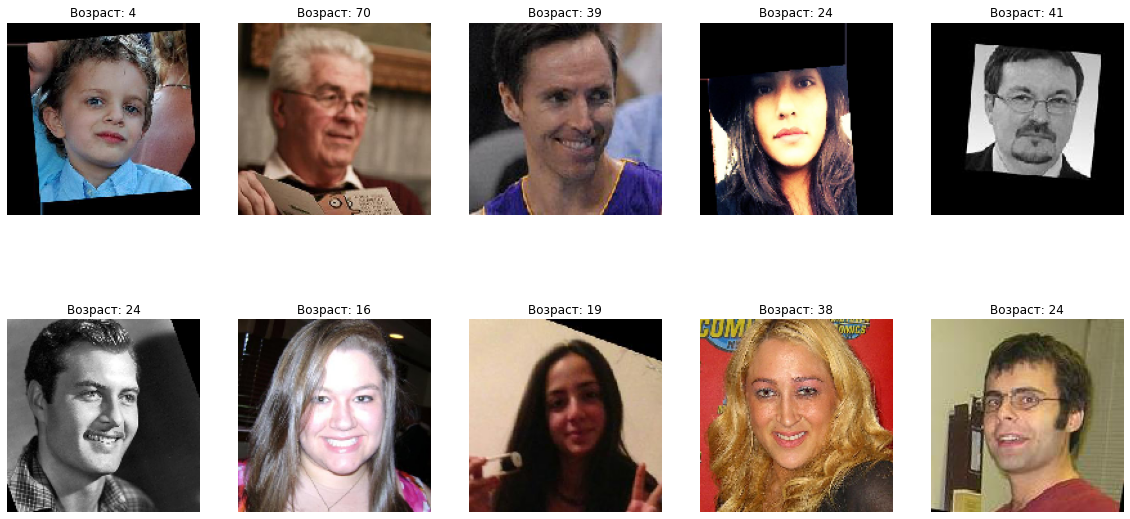

In [ ]:
# Выведем на экран часть изображений
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.axis('off')

plt.show()

На большей части изображений лицо полностью помещается в кадр и располагается по центру. При этом есть фотографии, на которых некоторые участки затемнены, например, третье изображение во второй строке или четвёртая фотография в первой. Также, некоторые фото оказались смещены относительно своих рамок, что может быть связано с предварительной обработкой: вероятно, чтобы черты лица находились в центре кадра, их немного видоизменили. Изображения представлены как в цветном, так и в ч/б вариантах.

# Промежуточный вывод

Датасет содержит 7 591 фото людей в возрасте от 1 до 100 лет, преимущественно (75%) - до 41 года. Средний возраст составляет 31 год, медианный - 29 лет. На изображениях лица расположены в центре, представлены как анфас, так и в три четверти, есть фотографии как в цвете, так и в черно-белом варианте.

## Обучение модели

Для увеличения объёма данных воспользуемся следующими типами аугментации:  
- горизонтальное отражение (horizontal_flip),  
- смешение по ширине и высоте (width_shift_range и height_shift_range),  
- уменьшение кадра (zoom_range).  

Сеть обучим на основе предобученной ResNet50 с оптимизатором Adam (learning rate=0.00001). В качестве loss-функции будет выступать MSE, а в качеcтве метрики - MAE.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255,
        horizontal_flip=True,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.1
    )
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(150, 150),
        batch_size=32,
        subset='training',
        seed=12346
    )
    
    return train_datagen_flow
    
def load_test(path):
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255
    )
    
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(150, 150),
        batch_size=32,
        subset='validation',
        seed=12346
    )
    
    return test_datagen_flow
    
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.00001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

2025-06-07 03:06:25.300102: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-06-07 03:06:25.378248: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-06-07 03:06:30.800680: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-06-07 03:06:31.237759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-06-07 03:06:31.237830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-06-07 03:06:31.237862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-06-07 03:06:31.352516: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-06-07 03:06:31.363772: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-06-07 03:06:31.702781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-06-07 03:06:31.733593: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-06-07 03:06:31.733713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-06-07 03:06:31.736847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2025-06-07 03:06:32.297210: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-06-07 03:06:32.424541: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2025-06-07 03:06:32.426228: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x47b0cf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-06-07 03:06:32.426261: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-06-07 03:06:32.606484: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x58c8440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-07 03:06:32.606522: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-06-07 03:06:32.608288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-06-07 03:06:32.608338: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-06-07 03:06:32.608347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-06-07 03:06:32.608374: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-06-07 03:06:32.608383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-06-07 03:06:32.608392: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-06-07 03:06:32.608400: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-06-07 03:06:32.608407: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-06-07 03:06:32.611741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-06-07 03:06:32.616171: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-06-07 03:06:34.513374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-06-07 03:06:34.513418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0
2025-06-07 03:06:34.513426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N
2025-06-07 03:06:34.516551: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-06-07 03:06:34.516600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2025-06-07 03:06:52.703705: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-06-07 03:06:53.936923: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 92s - loss: 949.5774 - mae: 26.2903 - val_loss: 1114.8662 - val_mae: 28.8614
Epoch 2/20
178/178 - 61s - loss: 313.8514 - mae: 13.9154 - val_loss: 1094.9005 - val_mae: 28.5238
Epoch 3/20
178/178 - 61s - loss: 167.8124 - mae: 9.7346 - val_loss: 1067.6631 - val_mae: 28.0978
Epoch 4/20
178/178 - 61s - loss: 125.8986 - mae: 8.4511 - val_loss: 259.0565 - val_mae: 11.7027
Epoch 5/20
178/178 - 61s - loss: 108.7489 - mae: 7.8949 - val_loss: 118.3086 - val_mae: 8.1077
Epoch 6/20
178/178 - 61s - loss: 96.3492 - mae: 7.4706 - val_loss: 98.2688 - val_mae: 7.3810
Epoch 7/20
178/178 - 61s - loss: 87.6268 - mae: 7.1735 - val_loss: 111.3298 - val_mae: 8.1290
Epoch 8/20
178/178 - 61s - loss: 83.1022 - mae: 7.0256 - val_loss: 94.9388 - val_mae: 7.3641
Epoch 9/20
178/178 - 61s - loss: 75.6206 - mae: 6.7039 - val_loss: 93.9852 - val_mae: 7.2384
Epoch 10/20
178/178 - 61s - loss: 71.7521 - mae: 6.5505 - val_loss: 93.5356 - val_mae: 7.2292
Epoch 11/20
178/178 - 61s - loss: 69.3064 - mae: 6.4473 - val_loss: 109.7665 - val_mae: 8.0249
Epoch 12/20
178/178 - 61s - loss: 63.8468 - mae: 6.2255 - val_loss: 97.7285 - val_mae: 7.4712
Epoch 13/20
178/178 - 61s - loss: 59.3265 - mae: 5.9759 - val_loss: 92.1095 - val_mae: 7.2706
Epoch 14/20
178/178 - 61s - loss: 58.2734 - mae: 5.9234 - val_loss: 91.6099 - val_mae: 7.1590
Epoch 15/20
178/178 - 61s - loss: 54.7196 - mae: 5.7593 - val_loss: 88.8241 - val_mae: 7.0478
Epoch 16/20
178/178 - 61s - loss: 52.4294 - mae: 5.6072 - val_loss: 92.5884 - val_mae: 7.2995
Epoch 17/20
178/178 - 61s - loss: 49.7486 - mae: 5.4885 - val_loss: 91.9493 - val_mae: 7.1124
Epoch 18/20
178/178 - 61s - loss: 47.4465 - mae: 5.3541 - val_loss: 91.7815 - val_mae: 7.2822
Epoch 19/20
178/178 - 61s - loss: 47.5274 - mae: 5.3617 - val_loss: 95.1931 - val_mae: 7.4550
Epoch 20/20
178/178 - 61s - loss: 45.8857 - mae: 5.2557 - val_loss: 88.8643 - val_mae: 7.1093
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 88.8643 - mae: 7.1093

```

## Анализ обученной модели

Модель успешно обучена, достигнуто значение MAE ниже 8:
- MAE = 7.1093  

Подобрано хорошее значение learning_rate: метрика MAE валидационной выборки уменьшается равномерно, с уменьшением на каждой эпохе без сильных скачков.
Видно, что на каждой эпохе функция потерь уменьшается на валидационной выборке вместе с тренировочной. Нет проблемы переобучения.